In [ ]:
https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

In [58]:
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join
from glob import glob

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [23]:
xrays_folder = r'D:\Downloads\Kaggle\Mask\Lung Segmentation\CXR_png'
masks_folder = r'D:\Downloads\Kaggle\Mask\Lung Segmentation\masks'
data_dir     = r'D:\Downloads\Kaggle\Mask\Lung Segmentation\all'

masks = np.asanyarray([f for f in listdir(masks_folder) if isfile(join(masks_folder, f))], dtype='object')

master = pd.DataFrame(masks, columns=['mask'])
master['xray'] = master.applymap(lambda x: x.replace('_mask',''))
master = master[['xray', 'mask']]

In [132]:
@tf.function
def load_image_train(row):
    img, mask = row
    input_img  = tf.keras.preprocessing.image.load_img(path = join(data_dir,img)).resize((128,128))
    input_mask = tf.keras.preprocessing.image.load_img(path = join(data_dir,mask)).resize((128,128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_img)
        input_mask = tf.image.flip_left_right(input_mask)
    
    return input_img, input_mask

In [133]:
@tf.function
def load_image_test(row):
    img, mask = row
    input_img  = tf.keras.preprocessing.image.load_img(path = join(data_dir,img)).resize((128,128))
    input_mask = tf.keras.preprocessing.image.load_img(path = join(data_dir,mask)).resize((128,128))

    return input_img, input_mask

In [134]:
Xtrain_i, Xtest_i, ytrain_i, ytest_i = train_test_split(range(master.shape[0]),range(master.shape[0]),
                                                    test_size=0.3)

In [135]:
Xtrain = master.iloc[Xtrain_i]
ytrain = master.iloc[ytrain_i]
Xtest  = master.iloc[Xtest_i]
ytest  = master.iloc[ytest_i]

In [136]:
TRAIN_LENGTH = Xtrain.shape[0]
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [151]:
a = pd.DataFrame(train)
b = pd.DataFrame(train)

In [137]:
train = Xtrain.apply(func = load_image_train, axis = 1)
test  = Xtest.apply(func = load_image_test, axis = 1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: If not matching a CFG node, must be a block statement: <gast.gast.Import object at 0x0000021C41060AC8>
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: If not matching a CFG node, must be a block statement: <gast.gast.Import object at 0x0000021C41060AC8>
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [98]:
#train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
#test_dataset = test.batch(BATCH_SIZE)

In [138]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

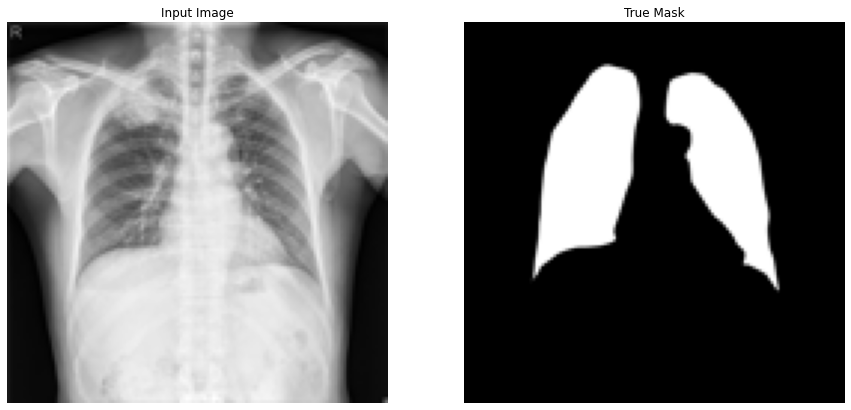

In [139]:
for img, mask in train:
    sample_image, sample_mask = img, mask
display([sample_image, sample_mask])

In [140]:
OUTPUT_CHANNELS = 2

In [141]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [142]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [143]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [144]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [145]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [146]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

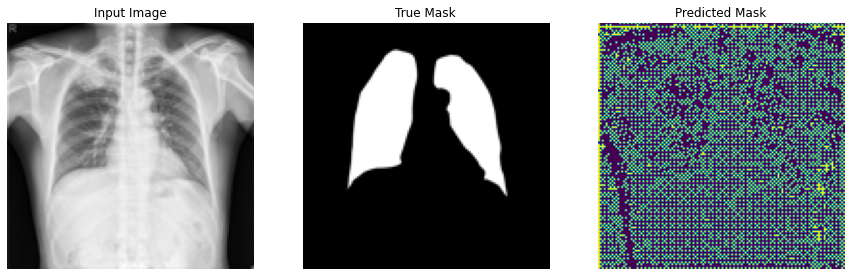

In [147]:
show_predictions()

In [148]:
class DisplayCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [149]:
EPOCHS = 2
VAL_SUBSPLITS = 5
VALIDATION_STEPS = Xtest.shape[0]//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

ValueError: Error when checking input: expected input_7 to have 4 dimensions, but got array with shape (492, 1)